# **DS-GA 1001 Final Project _ Analysis on Pure Price (Bixing)** 
## Team name: Maple Syrup
### Danfeng Li,  dl3983@nyu.edu
### Zexi Ye,  zy1311@nyu.edu
### Yucong Hu, yh2860@nyu.edu
### Bixing Yan,  by783@nyu.edu



In [0]:
!pip install tushare
!pip install xlrd

    100% |████████████████████████████████| 163kB 4.2MB/s 
    100% |████████████████████████████████| 5.8MB 4.8MB/s 
    100% |████████████████████████████████| 81kB 22.1MB/s 
  Running setup.py bdist_wheel for tushare ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/9d/28/e4/3d4f79eb35db275d679e5af64bfe6532f3f170fb8f2e4cee8b
  Running setup.py bdist_wheel for simplejson ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built tushare simplejson
    100% |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib

from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime

import tushare as ts

from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [0]:
from sklearn.metrics import accuracy_score

# 1 Data input

In [0]:
# 设置tushare pro的token并获取连接
#https://tushare.pro/document/1?doc_id=63

ts.set_token('6f8de8c580d8208f00ef68d0371dcb0a2070741fbb789b5dcf4e6c2e')
pro = ts.pro_api()


In [0]:
start_dt = '20130101'
end_dt ='20180101'

df = pro.index_daily(ts_code='399300.SZ', start_date=start_dt, end_date=end_dt)
df.head(5)

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,399300.SZ,20171229,4030.8549,4022.8826,4043.1400,4012.8749,4018.8974,11.9575,0.2975,90486683.0,121257038.5
1,399300.SZ,20171228,4018.8974,3992.9970,4036.6975,3980.2358,3991.2075,27.6899,0.6938,118542886.0,153636695.7
2,399300.SZ,20171227,3991.2075,4045.2793,4047.7366,3986.7385,4053.6224,-62.4149,-1.5397,105153577.0,140516907.1
3,399300.SZ,20171226,4053.6224,4040.6173,4056.8554,4015.2996,4041.5401,12.0823,0.2990,91118790.0,119725100.6
4,399300.SZ,20171225,4041.5401,4057.4173,4086.9342,4026.4496,4054.5984,-13.0583,-0.3221,91926962.0,129938839.1


# ARIMA model on price prediction

In [0]:
np.random.seed(0)

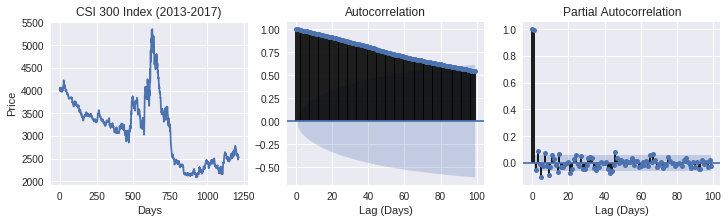

In [0]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(1,3,1)
ax1.plot(df['close'])
ax1.set_title('CSI 300 Index (2013-2017)')
ax1.set_ylabel('Price')
ax1.set_xlabel('Days')

ax3 = fig.add_subplot(1,3,2)
plot_acf(df['close'].values,lags=np.arange(0,100),ax=ax3)
ax3.set_xlabel('Lag (Days)')


ax4 = fig.add_subplot(1,3,3)
plot_pacf(df['close'].values,lags=np.arange(0,100),ax=ax4)
ax4.set_xlabel('Lag (Days)')
plt.show()

Here we can find that the price is not stationary

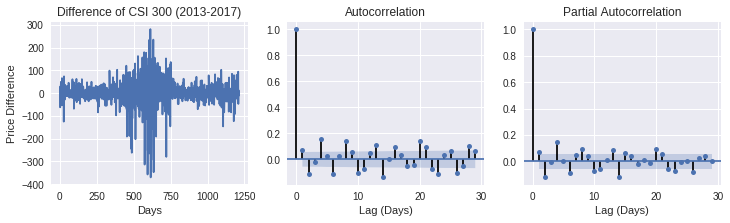

In [0]:
difference=df['close'][:-1].values-df['close'][1:].values

fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(1,3,1)
ax1.plot(difference)
ax1.set_title('Difference of CSI 300 (2013-2017)')
ax1.set_ylabel('Price Difference')
ax1.set_xlabel('Days')

ax3 = fig.add_subplot(1,3,2)
plot_acf(difference,lags=np.arange(0,30),ax=ax3)
ax3.set_xlabel('Lag (Days)')

ax4 = fig.add_subplot(1,3,3)
plot_pacf(difference,lags=np.arange(0,30),ax=ax4)
ax4.set_xlabel('Lag (Days)')
plt.show()

The difference of the price is stationary. Thus, the time series data is ARIMA(p,1,q)

And the possible p is [0,2,4,6,8,10,13,14,20]

The possible q is [0,2,4,6,8]

To select p and q, we will check their scores (AIC, BIC and HQIC)

In [0]:

'''AIC_matrix=np.full([33,33],np.inf)
BIC_matrix=np.full([33,33],np.inf)
HQIC_matrix=np.full([33,33],np.inf)

for i in [0,2,4,6,8,10,13,14,20]:
  for j in [0,2,4,6,8]:
    try:
      model = ARIMA(df['close'].values, order=(i,1,j))
      model_fit = model.fit(disp=0)
      AIC_matrix[i][j]=model_fit.aic
      BIC_matrix[i][j]=model_fit.bic
      HQIC_matrix[i][j]=model_fit.hqic
      print(i,j,'finished')
    except:
      pass
'''

"AIC_matrix=np.full([33,33],np.inf)\nBIC_matrix=np.full([33,33],np.inf)\nHQIC_matrix=np.full([33,33],np.inf)\n\nfor i in [0,2,4,6,8,10,13,14,20]:\n  for j in [0,2,4,6,8]:\n    try:\n      model = ARIMA(df['close'].values, order=(i,1,j))\n      model_fit = model.fit(disp=0)\n      AIC_matrix[i][j]=model_fit.aic\n      BIC_matrix[i][j]=model_fit.bic\n      HQIC_matrix[i][j]=model_fit.hqic\n      print(i,j,'finished')\n    except:\n      pass\n"

In [0]:
#aic_min_idx=np.unravel_index(AIC_matrix.argmin(), AIC_matrix.shape)
#bic_min_idx=np.unravel_index(BIC_matrix.argmin(), BIC_matrix.shape)
#hqic_min_idx=np.unravel_index(HQIC_matrix.argmin(), HQIC_matrix.shape)
#https://stackoverflow.com/questions/3584243/get-the-position-of-the-biggest-item-in-a-numpy-array

In [0]:
#aic_min_idx# (20, 6), ConvergenceWarning

In [0]:
#AIC_matrix[aic_min_idx] #13042.999014726805

In [0]:
#bic_min_idx#(2, 2)

In [0]:
#BIC_matrix[bic_min_idx]#13109.607628917081

In [0]:
#hqic_min_idx#(14, 4),ConvergenceWarning

In [0]:
#HQIC_matrix[hqic_min_idx]#13089.434058268127

#### From the above process, we can see that the optimazed model selected by AIC and HQIC are not convergent, thus, here we use BIC are our score.

The model we chose is ARIMA(2,1,2):

In [0]:
bic_min_idx=(2,2)

In [0]:
arima_model = ARIMA(df['close'].values, order=(bic_min_idx[0],1,bic_min_idx[1]))
arima_fit = arima_model.fit(disp=0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


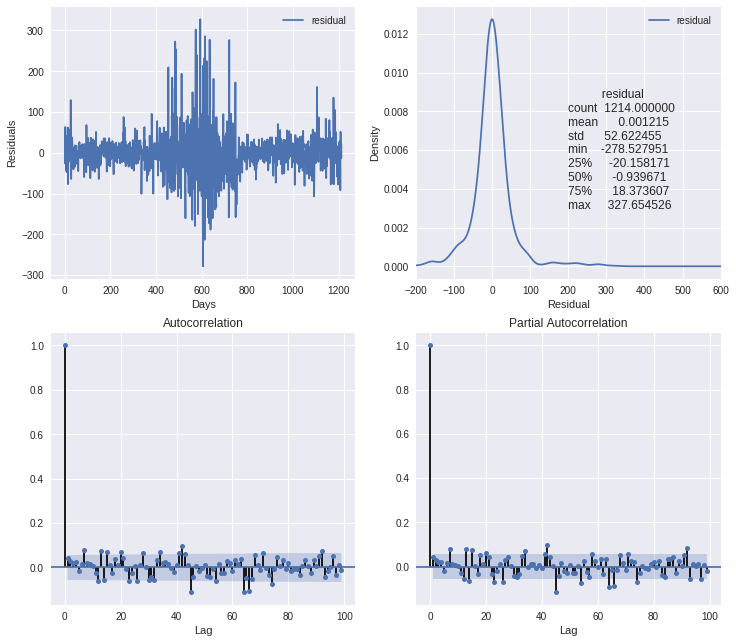

In [0]:
# plot residual errors


fig=plt.figure(figsize=(12,11))

ax1 = fig.add_subplot(2,2,1)
residuals =  pd.DataFrame(arima_fit.resid).rename(columns={0:'residual'})
residuals.plot(ax=ax1)
s=residuals.describe().rename(columns={0:'residual'}).to_string()
ax1.set_xlabel('Days')
ax1.set_ylabel('Residuals')

ax2=fig.add_subplot(2,2,2)
residuals.plot(kind='kde',ax=ax2)
ax2.set_xlabel('Residual')

ax2.set_xlim([-200,600])
ax2.text(200,0.003,s)


ax3=fig.add_subplot(2,2,3)
plot_acf(residuals.values,lags=np.arange(0,100),ax=ax3)
ax3.set_xlabel('Lag')

ax4=fig.add_subplot(2,2,4)
plot_pacf(residuals.values,lags=np.arange(0,100),ax=ax4)
ax4.set_xlabel('Lag')
plt.show()

From the acf and pacf, we can see that residual is close to white noise. Although not so white from the residual plot itself.

In [0]:
# code from
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
X = df['close'].values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
  model = ARIMA(history, order=(bic_min_idx[0],1,bic_min_idx[1]))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  if (t!=0)&(t%10==0):
    print('%d/%d prediction are finished'%(t,len(test)))
	#print('predicted=%f, expected=%f' % (yhat, obs))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


10/122 prediction are finished
20/122 prediction are finished
30/122 prediction are finished
40/122 prediction are finished
50/122 prediction are finished
60/122 prediction are finished
70/122 prediction are finished
80/122 prediction are finished
90/122 prediction are finished
100/122 prediction are finished
110/122 prediction are finished
120/122 prediction are finished


In [0]:
error = np.sqrt(mean_squared_error(test, predictions))
print('Test Standard Deviation: %.3f' % error)

Test Standard Deviation: 40.247


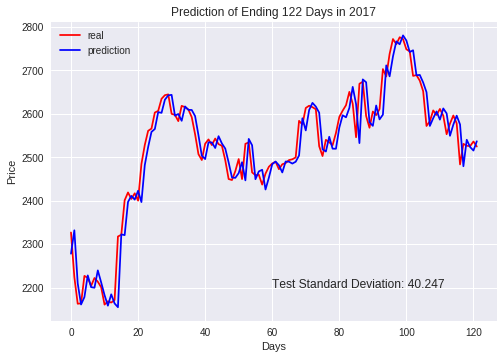

In [0]:
# plot
plt.plot(test,color='red',label='real')
plt.plot(predictions, color='blue',label='prediction')
plt.title('Prediction of Ending %d Days in 2017'%len(test))
plt.ylabel('Price')
plt.xlabel('Days')
plt.text(60,2200,'Test Standard Deviation: %.3f' % error)
plt.legend()
plt.show()

In [0]:

pred_true=0
for i in range(len(test)-1):
  if (test[i+1]-test[i])*(predictions[i+1]-predictions[i])>0:
    pred_true+=1
print('accuarcy of ARIMA is %.4f %%'%(100*pred_true/(len(test)-1) ) )
    

accuarcy of ARIMA is 50.4132 %


In [0]:
np.random.seed(1992)
random_predictions=np.random.randint(0,2,len(test)-1)
test_up_down_list=[]
for i in range(len(test)-1):
  if (test[i+1]-test[i])>0: test_up_down_list.append(1)
  else: test_up_down_list.append(0)
print('accuarcy of random guess is %.4f %%'%(100*accuracy_score(test_up_down_list,random_predictions) ) )

accuarcy of random guess is 47.1074 %


In [0]:
np.random.seed(0)
only_1_prediction=[1]*(len(test)-1)#np.random.randint(0,2,len(test)-1)
print('accuarcy of random guess is %.4f %%'%(100*accuracy_score(test_up_down_list,only_1_prediction) ) )

accuarcy of random guess is 51.2397 %


# LSTM on Pure Price

In [0]:
# LSTM 
# Still need to be modified

def Simple_LSTM_Multi_Days(Prev_Days,num_units,epoch_num):
    np.random.seed(0)
    
    
    row=df['close'].values
    
    
    row_len=len(row)
    DataSet1 = row[0:row_len-1]
    
    X=[]
    for i in range(0,row_len-Prev_Days):
        X.append(DataSet1[i:i+Prev_Days])
    
    y = row[Prev_Days:row_len]
    
    X_train, X_test, y_train, y_test = X[0:size], X[size:len(X)], y[0:size], y[size:len(X)]#train_test_split(X, y, test_size = 0.1, random_state = 0)
    
    ##### state to process data
    
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,Prev_Days))
    y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
    y_train = sc.fit_transform(y_train)
    
    X_train_len=X_train.shape[0]
    X_train = np.reshape(X_train, (X_train_len,1,Prev_Days))

    regressor = Sequential()
    regressor.add(LSTM(units = num_units, activation = 'relu', input_shape = (None, Prev_Days)))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(X_train, y_train, batch_size = 10, epochs = epoch_num, verbose = 0)
    
    
    # Getting the predicted Value
    inputs = X_test
    inputs = np.reshape(inputs,(-1,Prev_Days))
    inputs = sc.transform(inputs)
    
    inputs_len=inputs.shape[0]
    
    inputs = np.reshape(inputs, (inputs_len, 1, Prev_Days))
    y_pred = regressor.predict(inputs)
    y_pred = sc.inverse_transform(y_pred)
    y_pred_rs=np.reshape(y_pred,(-1,))
    
    plt.figure
    plt.plot(y_test, color = 'red', label = 'Real Test Data')
    plt.plot(y_pred, color = 'blue', label = 'Predicted test Data')
    plt.title('Forecasting--LSTM Model \n Number of Days Input:%d'%(Prev_Days))
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.text(60,2200,'Test Standard Deviation: %.3f' % sqrt(mean_squared_error(y_test, y_pred_rs)))
    plt.show()
    
    plt.figure
    plt.scatter(y_test,y_pred)
    plt.title('Real Data vs Prediction, Number of Days Input:%d'%(Prev_Days) )
    plt.xlabel('Price')
    plt.ylabel('Price_Predicted')
    plt.show()
    
    
    
    print('the correlation coefficient between test and prediction is %.2f'%np.corrcoef(y_test, y_pred_rs)[0,1])
    print('the RMSE between test and prediction is %.2f'%sqrt(mean_squared_error(y_test, y_pred_rs)))
    return np.corrcoef(y_test, y_pred_rs)[0,1],sqrt(mean_squared_error(y_test, y_pred_rs))
  
  

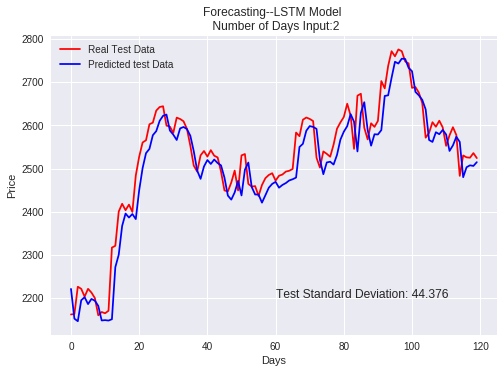

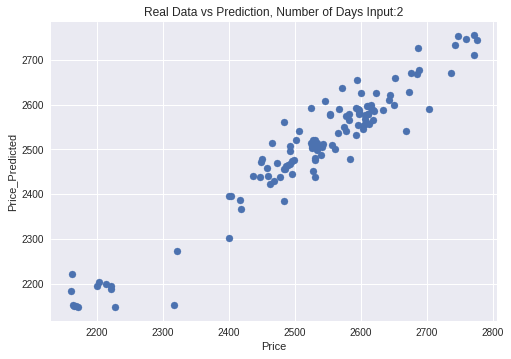

the correlation coefficient between test and prediction is 0.96
the RMSE between test and prediction is 44.38


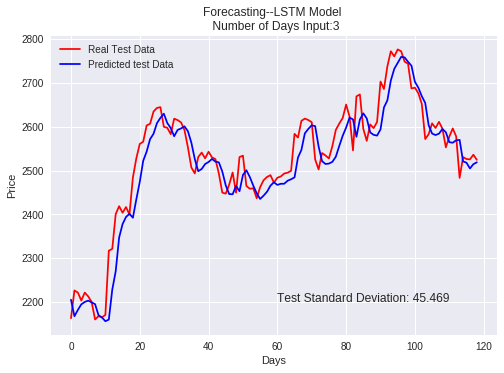

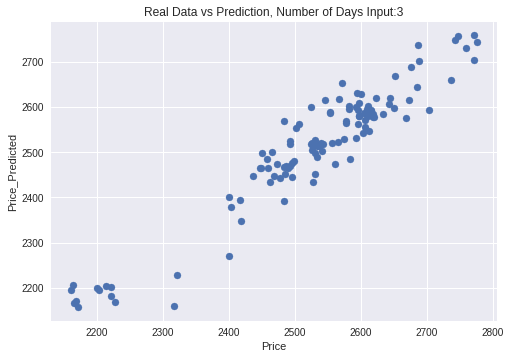

the correlation coefficient between test and prediction is 0.95
the RMSE between test and prediction is 45.47


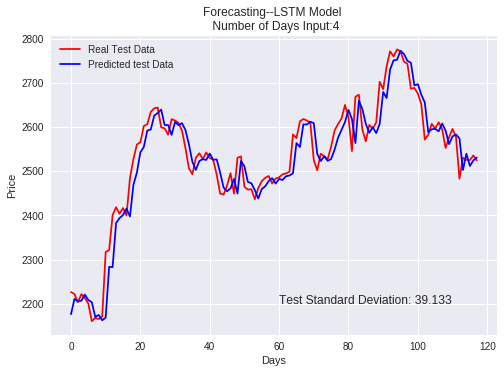

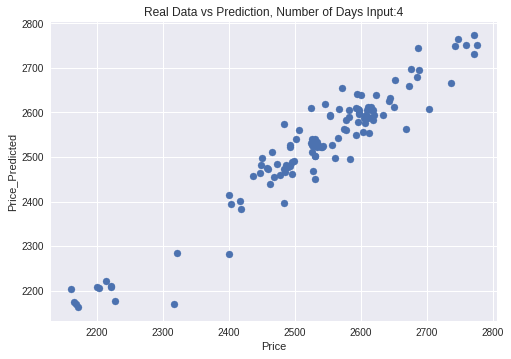

the correlation coefficient between test and prediction is 0.96
the RMSE between test and prediction is 39.13


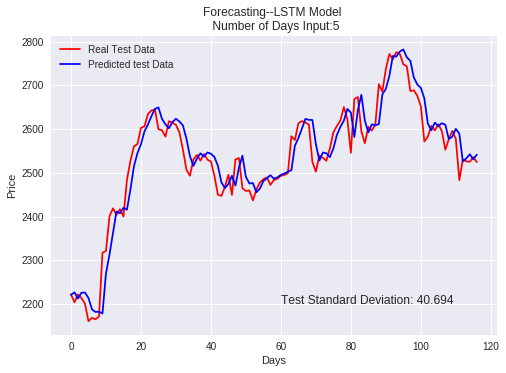

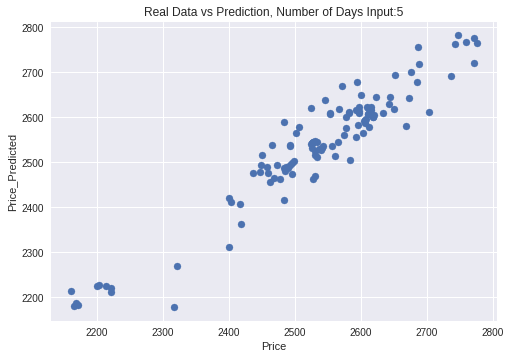

the correlation coefficient between test and prediction is 0.95
the RMSE between test and prediction is 40.69


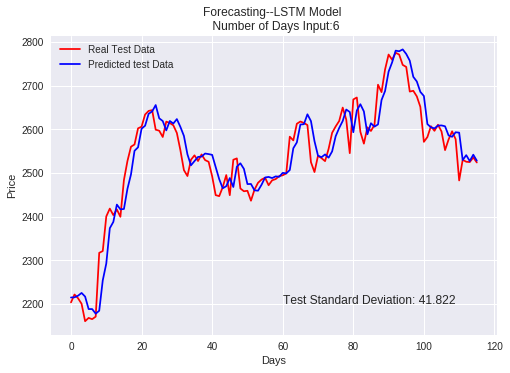

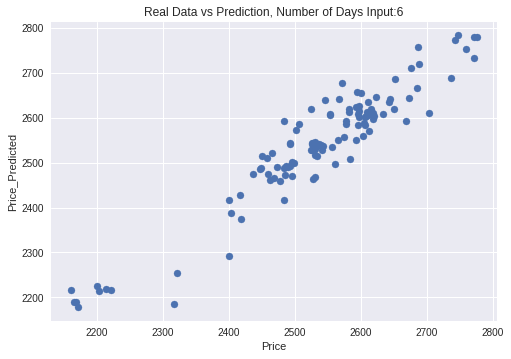

the correlation coefficient between test and prediction is 0.95
the RMSE between test and prediction is 41.82


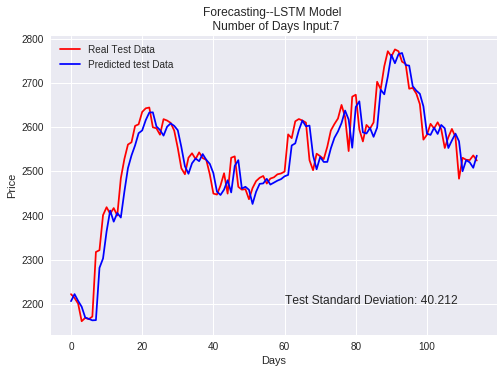

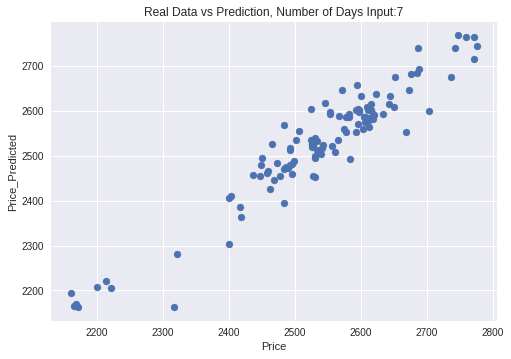

the correlation coefficient between test and prediction is 0.95
the RMSE between test and prediction is 40.21


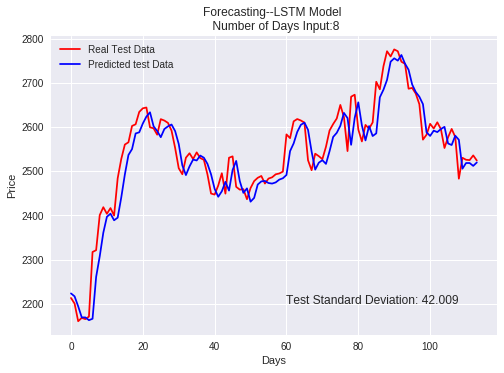

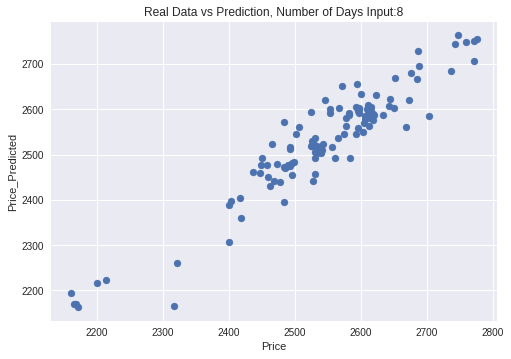

the correlation coefficient between test and prediction is 0.95
the RMSE between test and prediction is 42.01


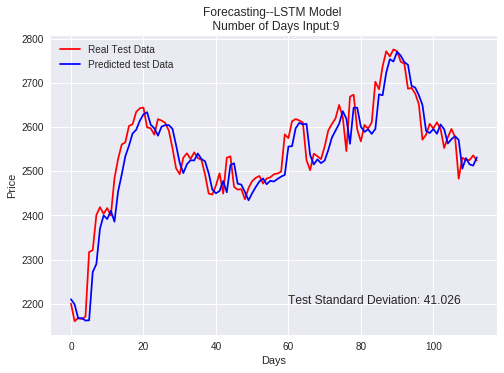

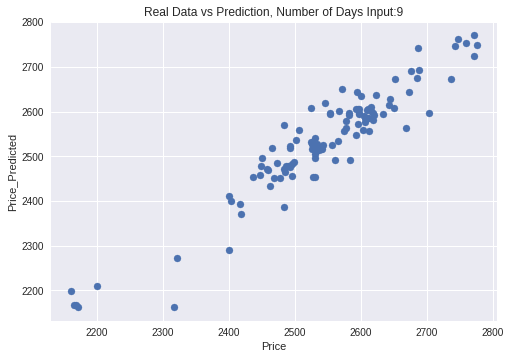

the correlation coefficient between test and prediction is 0.95
the RMSE between test and prediction is 41.03


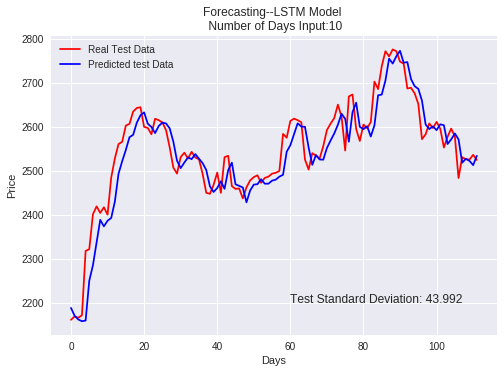

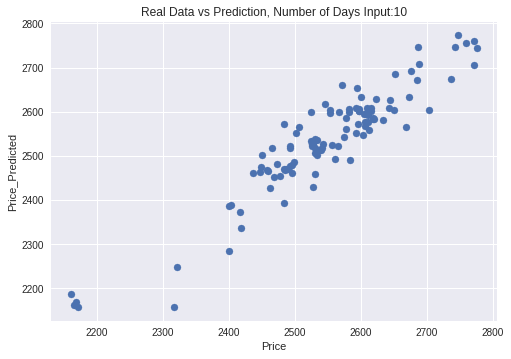

the correlation coefficient between test and prediction is 0.94
the RMSE between test and prediction is 43.99


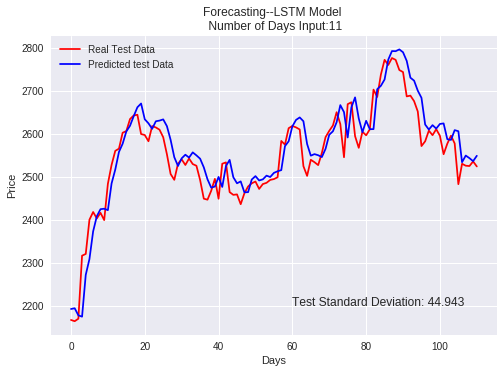

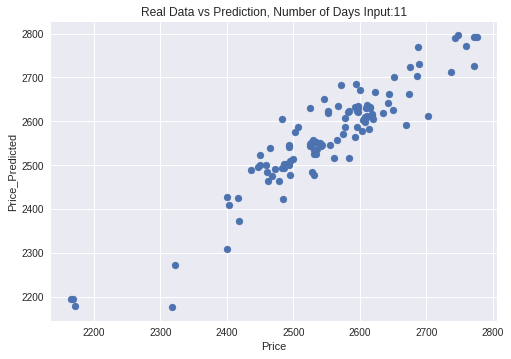

the correlation coefficient between test and prediction is 0.93
the RMSE between test and prediction is 44.94


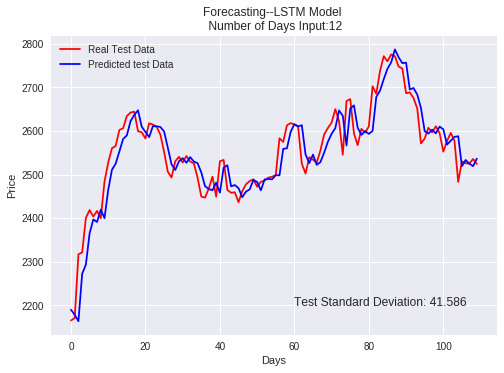

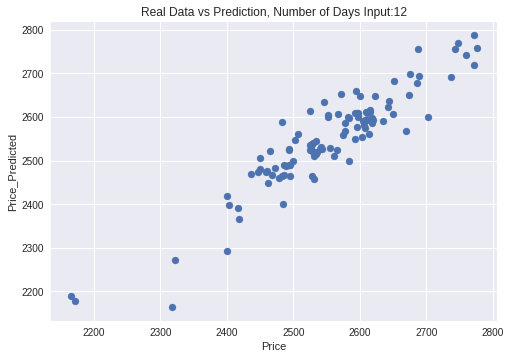

the correlation coefficient between test and prediction is 0.93
the RMSE between test and prediction is 41.59


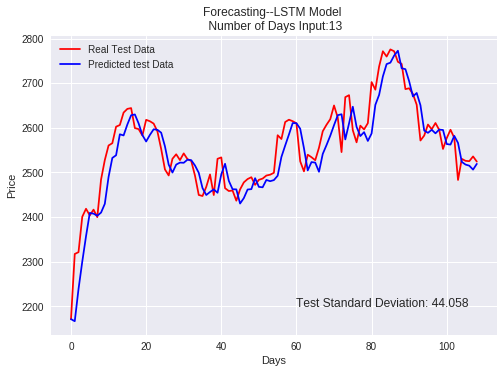

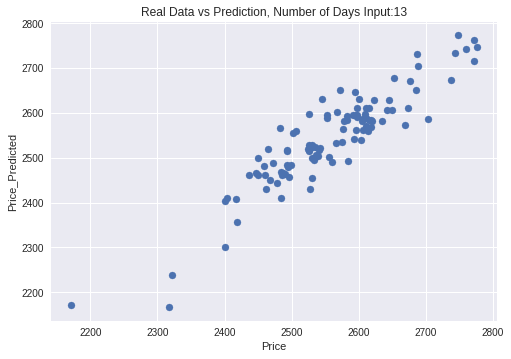

the correlation coefficient between test and prediction is 0.92
the RMSE between test and prediction is 44.06


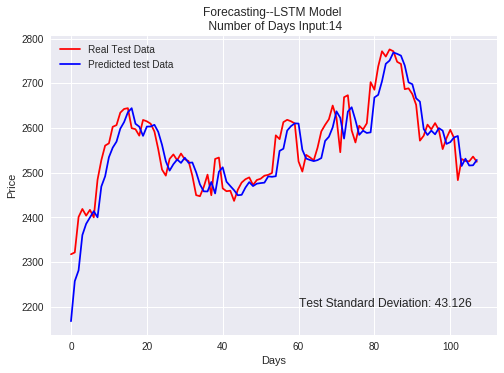

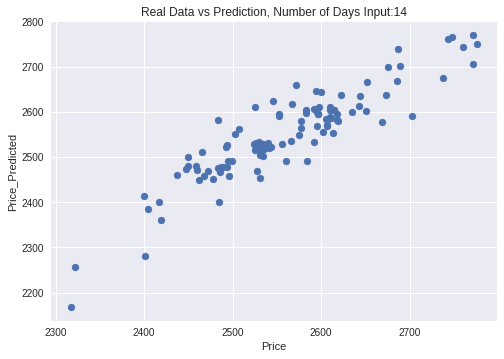

the correlation coefficient between test and prediction is 0.91
the RMSE between test and prediction is 43.13


In [0]:
input_size_list=[]
LSTM_std_list=[]
for i in range(2,15):
  input_size_list.append(i)
  LSTM_std_list.append(Simple_LSTM_Multi_Days(i,8,100)[1])
  
  

In [0]:
# what if we directly use previous day's price as todays price?
prev_day_std=sqrt(mean_squared_error(df['close'].values[1:],df['close'].values[:-1]))

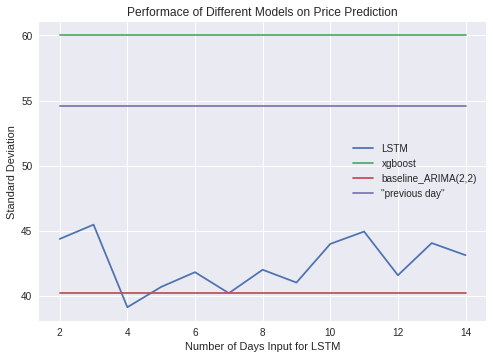

In [0]:
plt.plot(input_size_list,LSTM_std_list,label='LSTM')
plt.plot(input_size_list,[60]*len(input_size_list),label='xgboost')
plt.plot(input_size_list,[error]*len(input_size_list),label='baseline_ARIMA(2,2)')
plt.plot(input_size_list,[prev_day_std]*len(input_size_list),label='\"previous day\"')
plt.title('Performace of Different Models on Price Prediction')
plt.xlabel('Number of Days Input for LSTM')
plt.ylabel('Standard Deviation')
plt.legend()#loc=5)
plt.show()

#### this implies without other input, the LSTM at least is not better than traditional ML method

#### this is because the LSTM is a determisitic model while ARIMA includes the consideration of noise distribution, which consider the randomness of the system.

#### Although not so good, but still better than random guess

#### Thus, our models do have some predict power.

In [0]:
# LSTM 
# Still need to be modified

def up_down_trans(x):
  if x>0.5:return 1
  else: return 0

def Simple_LSTM_Multi_Days_2(Prev_Days,num_units,epoch_num):
  
    
    
    np.random.seed(0)  
    row=df['close'].values
    
    
    row_len=len(row)
    DataSet1 = row[0:row_len-1]
    
    X=[]
    for i in range(0,row_len-Prev_Days):
        X.append(DataSet1[i:i+Prev_Days])
    
    #y = row[Prev_Days:row_len]
    y=[]
    for i in range(Prev_Days,row_len-1):
      if row[i+1]>row[i]:y.append(1)
      else:y.append(0)
        
    #y = to_categorical(y)
    
    X_train, X_test, y_train, y_test = X[0:size], X[size:len(X)-1], y[0:size], y[size:len(X)-1]#train_test_split(X, y, test_size = 0.1, random_state = 0)
    
    ##### state to process data
    
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,Prev_Days))
    #y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
    #y_train = sc.fit_transform(y_train)
    
    X_train_len=X_train.shape[0]
    X_train = np.reshape(X_train, (X_train_len,1,Prev_Days))

    regressor = Sequential()
    regressor.add(LSTM(units = num_units, activation = 'relu', input_shape = (None, Prev_Days)))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    regressor.fit(X_train, y_train, batch_size = 10, epochs = epoch_num, verbose = 0)
    
    
    # Getting the predicted Value
    inputs = X_test
    inputs = np.reshape(inputs,(-1,Prev_Days))
    inputs = sc.transform(inputs)
    
    inputs_len=inputs.shape[0]
    
    inputs = np.reshape(inputs, (inputs_len, 1, Prev_Days))
    y_pred = regressor.predict(inputs)
    #y_pred = sc.inverse_transform(y_pred)
    
    
    #y_pred_rs=np.reshape(y_pred,(-1,))
    
    return accuracy_score(y_test,list(map(up_down_trans,y_pred)))

In [0]:
input_size_list_2=[]
LSTM_up_down_accuracy_list=[]
for i in range(2,15):
  input_size_list_2.append(i)
  LSTM_up_down_accuracy_list.append(Simple_LSTM_Multi_Days_2(i,8,100))
  print(i,'is finished')

In [0]:
plt.plot(input_size_list_2,LSTM_up_down_accuracy_list,label='LSTM')
plt.plot(input_size_list_2,[0.532]*len(input_size_list_2),label='xgboost')
plt.plot(input_size_list_2,[pred_true/(len(test)-1)]*len(input_size_list_2),label='baseline_ARIMA(2,2)')
plt.plot(input_size_list_2,[accuracy_score(test_up_down_list,random_predictions)]*len(input_size_list_2),label='\"random guess\"')
plt.plot(input_size_list_2,[accuracy_score(test_up_down_list,only_1_prediction)]*len(input_size_list_2),label='\"only increase\"')

plt.title('Performace of Different Models on "up or down" Prediction')
plt.xlabel('Number of Days Input for LSTM')
plt.ylabel('Accuracy of Prediction')
plt.legend()#loc=5)
plt.show()

#### this implies interms of the price trend, the LSTM deed performs better than ARIMA

#### Although the ARIMA have more precise prediction in price value, this precision comes from the assumption that the noise has certain distribution.

#### This remind me the technical analysis where people find "patterns" in price and predict the future price trends. LSTM may find hidden pattern in the price data and thus have a very good performance on price trend prediction.

In [0]:
#####